# Lab 5: Training & hyperparameter tuning TensorFlow with Azure ML

**Automate efficient hyperparameter tuning** by using Azure Machine Learning **HyperDrive package**. <br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

Learn how to complete the steps required to tune hyperparameters with the Azure Machine Learning SDK:

- Define the parameter search space
- Specify a primary metric to optimize
- Specify early termination policy for low-performing runs
- Allocate resources
- Launch an experiment with the defined configuration
- Visualize the training runs
- Select the best configuration for your model


**Hyperparameters are adjustable parameters** that let you control the model training process. For example, with neural networks, you decide the number of hidden layers and the number of nodes in each layer. Model performance depends heavily on hyperparameters.

Hyperparameter tuning is the process of finding the configuration of hyperparameters that results in the best performance. The process is typically computationally expensive and manual.

Azure Machine Learning lets you automate hyperparameter tuning and run experiments in parallel to efficiently optimize hyperparameters.

> Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters

This tutorial shows how to train a simple deep neural network using the MNIST dataset and TensorFlow on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/).

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2021-02-01 14:21:58.915579


In [3]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
import azureml.core
print("This Jupyter notebook was made using Azure ML 1.21.0")
print("You are using Azure ML", azureml.core.VERSION)

This Jupyter notebook was made using Azure ML 1.21.0
You are using Azure ML 1.21.0


## Experimentation

In [6]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [7]:
from azureml.core import Experiment

script_folder = './sample_projects/lab5'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='Lab5-HyperparameterTuning')

## Data

In [8]:
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')

('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x7f97de9574a8>)

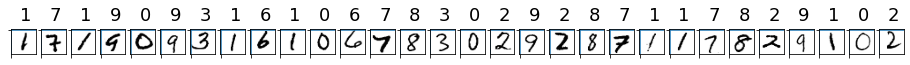

In [9]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Create a Dataset for Files
A Dataset can reference single or multiple files in your datastores or public urls. The files can be of any format. Dataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [10]:
from azureml.core.dataset import Dataset
web_paths = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
             'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
             'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
             'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

In [11]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist dataset',
                           description='training and test dataset',
                           create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/http%3A/%2Fyann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

## Azure ML Compute

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [12]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, "(" , ct.type, ") :", ct.provisioning_state)

AzureDatabricks ( Databricks ) : Succeeded
instanceaks ( AKS ) : Succeeded
automl ( AmlCompute ) : Succeeded
designer ( AmlCompute ) : Succeeded
instancenbooks ( ComputeInstance ) : Succeeded
automlcpu ( AmlCompute ) : Succeeded
CPUcluster ( AmlCompute ) : Succeeded


### Let's create a GPU Azure ML cluster

In [13]:
%%time
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#Use an unique name
cluster_name = "clusterGPU"

# Tags
clusttags= {"Type": "GPU", 
            "Priority":"Dedicated",
            "Team" : "DataScience", 
            "Country" : "France"}

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', # A GPU instance
                                                           min_nodes=0,
                                                           max_nodes=8,
                                                           vm_priority='dedicated',
                                                           tags=clusttags, 
                                                           description="Compute Clusters NC6",
                                                           idle_seconds_before_scaledown=1800)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-02-01T14:22:37.262000+00:00', 'errors': None, 'creationTime': '2021-02-01T14:22:34.363244+00:00', 'modifiedTime': '2021-02-01T14:22:49.877580+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 8, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}
CPU times: user 89.2 ms, sys: 1.59 ms, total: 90.8 ms
Wall time: 17.1 s


### Compute Cluster informations:

In [14]:
compute_target.serialize

<bound method AmlCompute.serialize of AmlCompute(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=clusterGPU, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/AMLworkshop-rg/providers/Microsoft.MachineLearningServices/workspaces/AMLworkshop/computes/clusterGPU, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags={'Type': 'GPU', 'Priority': 'Dedicated', 'Team': 'DataScience', 'Country': 'France'})>

In [15]:
compute_target.name

'clusterGPU'

In [16]:
compute_target.type

'AmlCompute'

In [17]:
compute_target.cluster_location

'westeurope'

In [18]:
compute_target.tags

{'Type': 'GPU',
 'Priority': 'Dedicated',
 'Team': 'DataScience',
 'Country': 'France'}

## Copy the training files into the script folder
The TensorFlow training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [19]:
import shutil

# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./sample_projects/lab5/utils.py'

## Construct neural network in TensorFlow
In the training script `tf_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.



In [20]:
with open(os.path.join(script_folder, './tf_mnist.py'), 'r') as f:
    print(f.read())

import numpy as np
import argparse
import os
import tensorflow as tf
import glob

from azureml.core import Run
from utils import load_data

print("TensorFlow version:", tf.__version__)

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=100,
                    help='# of neurons in the first layer')
parser.add_argument('--second-layer-neurons', type=int, dest='n_hidden_2', default=100,
                    help='# of neurons in the second layer')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.01, help='learning rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the

In the training script tf_mnist.py, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

<img src="https://github.com/Azure/MachineLearningNotebooks/raw/3adebd11278686a23c13434b42340acb248b3133/how-to-use-azureml/ml-frameworks/tensorflow/hyperparameter-tune-and-warm-start-with-tensorflow/nn.png">

In [21]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py',
                 use_gpu=True,
                 framework_version="1.13", # version TF
                 pip_packages=['azureml-dataprep[pandas,fuse]'])

'TensorFlow' estimator is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or one of the Azure ML TensorFlow curated environments.


In [22]:
tags = {"Framework" : "TensorFlow" , 
        "BatchSize" : "50" , 
        "H1" : "300" , 
        "H2" : "100" , 
        "LR" : "0.01"}

## Submit job to run
Submit the estimator to an Azure ML experiment to kick off the execution.

In [23]:
run = exp.submit(est, tags=tags)

### Monitor the Run <a class="anchor" id="monitor-run"></a>
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the Batch AI cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

> Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run

## Monitoring the Azure ML TensorFlow run

In [24]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [29]:
print('Run status =', run.get_status())

Run status = Completed


In [30]:
run.properties

{'_azureml.ComputeTargetType': 'amlcompute',
 'ContentSnapshotId': 'b6478bc8-5f7d-4e41-a8b6-90e614ddcc73',
 'ProcessInfoFile': 'azureml-logs/process_info.json',
 'ProcessStatusFile': 'azureml-logs/process_status.json'}

In [31]:
run.get_details()

{'runId': 'Lab5-HyperparameterTuning_1612189387_17f3295d',
 'target': 'clusterGPU',
 'status': 'Completed',
 'startTimeUtc': '2021-02-01T14:27:42.604824Z',
 'endTimeUtc': '2021-02-01T14:30:25.322943Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'b6478bc8-5f7d-4e41-a8b6-90e614ddcc73',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'ba55ec11-3b26-490e-b3a4-2f3cb61fb16e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'tf_mnist.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:mnist',
   '--batch-size',
   '50',
   '--first-layer-neurons',
   '300',
   '--second-layer-neurons',
   '100',
   '--learning-rate',
   '0.01'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'commun

In [32]:
run.get_metrics()

{'training_acc': [0.800000011920929,
  0.8999999761581421,
  0.9399999976158142,
  0.9800000190734863,
  0.9200000166893005,
  0.9800000190734863,
  0.9599999785423279,
  0.9200000166893005,
  0.9200000166893005,
  0.9599999785423279,
  0.9399999976158142,
  0.9399999976158142,
  0.9599999785423279,
  1.0,
  1.0,
  0.9200000166893005,
  0.8999999761581421,
  0.9599999785423279,
  1.0,
  1.0],
 'validation_acc': [0.9057999849319458,
  0.9225999712944031,
  0.9301000237464905,
  0.9380000233650208,
  0.9444000124931335,
  0.9480999708175659,
  0.9521999955177307,
  0.9560999870300293,
  0.95660001039505,
  0.9591000080108643,
  0.9638000130653381,
  0.9646999835968018,
  0.9656000137329102,
  0.96670001745224,
  0.9678999781608582,
  0.9686999917030334,
  0.9690999984741211,
  0.9710999727249146,
  0.9718999862670898,
  0.972599983215332],
 'final_acc': 0.972599983215332}

In [33]:
run.get_metrics('final_acc')

{'final_acc': 0.972599983215332}

In [34]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Lab5-HyperparameterTuning,Lab5-HyperparameterTuning_1612189387_17f3295d,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Plot accuracy over epochs
Since we can retrieve the metrics from the run, we can easily make plots using `matplotlib` in the notebook. Then we can add the plotted image to the run using `run.log_image()`, so all information about the run is kept together.

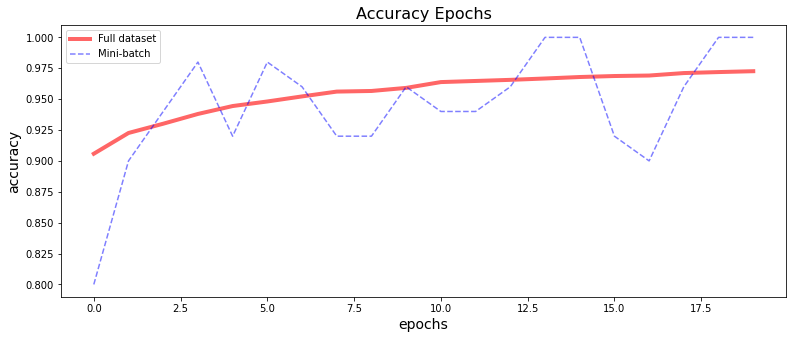

In [35]:
os.makedirs('./graphs', exist_ok=True)
metrics = run.get_metrics()

plt.figure(figsize = (13,5))
plt.plot(metrics['validation_acc'], 'r-', lw=4, alpha=.6)
plt.plot(metrics['training_acc'], 'b--', alpha=0.5)
plt.legend(['Full dataset', 'Mini-batch'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('Accuracy Epochs', fontsize=16)
run.log_image(name='TFgraph.png', plot=plt)
plt.show()

In [36]:
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Intelligent hyperparameter tuning with Azure HyperDrive

Hyperparameters are adjustable parameters you choose for model training that guide the training process. **The HyperDrive package** helps you automate choosing these parameters. <br>For example, you can define the parameter search space as discrete or continuous, and a sampling method over the search space as random, grid, or Bayesian. Also, you can specify a primary metric to optimize in the hyperparameter tuning experiment, and whether to minimize or maximize that metric. You can also define early termination policies in which poorly performing experiment runs are canceled and new ones started.

> Documentation: https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive?view=azure-ml-py

In [37]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100, 200),
        '--first-layer-neurons': choice(10, 50, 100, 200),
        '--second-layer-neurons': choice(5, 10, 50, 100),
        '--learning-rate': loguniform(-6, -1)
    }
)

In [38]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': dataset.as_named_input('mnist').as_mount()},
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=True,
                 framework_version="1.13", 
                 pip_packages=['azureml-dataprep[pandas,fuse]'])

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric. No Extra costs.

In [39]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [40]:
hypparmtuning = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='validation_acc', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=6,
                       max_concurrent_runs=4)

In [41]:
tags = {"Framework" : "TensorFlow 1.13", 
        "Hyperdrive" : "Yes"}

In [42]:
hypparmtuning = exp.submit(config=hypparmtuning, tags=tags)

### Let's run the hyperparameter tuning process:

In [43]:
RunDetails(hypparmtuning).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [44]:
#hypparmtuning.wait_for_completion(show_output=True)

### Checking the run:

In [47]:
print("The run is currently", hypparmtuning.get_status())

The run is currently Completed


In [48]:
hypparmtuning.get_diagnostics

<bound method HyperDriveRun.get_diagnostics of Run(Experiment: Lab5-HyperparameterTuning,
Id: HD_2543eb83-4e90-4bcd-8775-48d651c613cb,
Type: hyperdrive,
Status: Completed)>

In [49]:
hypparmtuning.properties

{'primary_metric_config': '{"name": "validation_acc", "goal": "maximize"}',
 'resume_from': 'null',
 'runTemplate': 'HyperDrive',
 'azureml.runsource': 'hyperdrive',
 'platform': 'AML',
 'ContentSnapshotId': 'b6478bc8-5f7d-4e41-a8b6-90e614ddcc73',
 'score': '0.9797999858856201',
 'best_child_run_id': 'HD_2543eb83-4e90-4bcd-8775-48d651c613cb_0',
 'best_metric_status': 'Succeeded'}

### Results are available in the widget and in the experiment as well:

In [50]:
hypparmtuning

Experiment,Id,Type,Status,Details Page,Docs Page
Lab5-HyperparameterTuning,HD_2543eb83-4e90-4bcd-8775-48d651c613cb,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


### We can save now the best model into the Azure ML model repository

In [51]:
best_run = hypparmtuning.get_best_run_by_primary_metric()

In [52]:
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_026e371f8a646ba50552698c5d5c6d4afe6350eb3b8da935116140b7aa0e9a2f_d.txt', 'azureml-logs/65_job_prep-tvmps_026e371f8a646ba50552698c5d5c6d4afe6350eb3b8da935116140b7aa0e9a2f_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_026e371f8a646ba50552698c5d5c6d4afe6350eb3b8da935116140b7aa0e9a2f_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/80_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_9052c54a-3d0c-4ec7-87f5-aa2fb9a8c55a.jsonl', 'logs/azureml/dataprep/engine_spans_c4694be4-cbbb-4f9e-a013-1c482226a490.jsonl', 'logs/azureml/dataprep/python_span_9052c54a-3d0c-4ec7-87f5-aa2fb9a8c55a.jsonl', 'logs/azureml/dataprep/python_span_c4694be4-cbbb-4f9e-a013-1c482226a490.jsonl', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'logs/azureml/sidecar/tvmps_026e371f8

In [53]:
best_run.get_properties

<bound method Run.get_properties of Run(Experiment: Lab5-HyperparameterTuning,
Id: HD_2543eb83-4e90-4bcd-8775-48d651c613cb_0,
Type: azureml.scriptrun,
Status: Completed)>

Registering the model:

In [54]:
model = best_run.register_model(model_name='TensorFlow-Lab5', 
                                model_path='outputs/model', 
                                tags={'Framework':'TensorFlow', 
                                      'Hyperdrive':'Yes', 
                                      'GPU':'Yes'}
                               )

In [55]:
model.created_time

datetime.datetime(2021, 2, 1, 14, 39, 53, 278067, tzinfo=<isodate.tzinfo.Utc object at 0x7f9828ea2518>)

In [56]:
model.serialize

<bound method Model.serialize of Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=TensorFlow-Lab5, id=TensorFlow-Lab5:14, version=14, tags={'Framework': 'TensorFlow', 'Hyperdrive': 'Yes', 'GPU': 'Yes'}, properties={})>

In [57]:
model.id

'TensorFlow-Lab5:14'

All models from the current workspace:

In [58]:
from azureml.core.model import Model
models = Model.list(ws)
for m in models:
    print(m.name, "( version:", m.version, ")")

TensorFlow-Lab5 ( version: 14 )
mnist-prs ( version: 14 )
sklearn_mnist ( version: 32 )
IBM_attrition_explainer ( version: 28 )
local_deploy_model ( version: 28 )
DiabetesRidgeModel ( version: 3 )
TensorFlow-Lab5 ( version: 13 )
mnist-prs ( version: 13 )
BestAutoMLModel ( version: 8 )
sklearn_mnist ( version: 31 )
IBM_attrition_explainer ( version: 27 )
local_deploy_model ( version: 27 )
DiabetesRidgeModel ( version: 2 )
TenYearCHD-model ( version: 6 )
DiabetesRidgeModel ( version: 1 )
DiabetesRidge ( version: 45 )
DiabetesRidge ( version: 44 )
DiabetesRidge ( version: 43 )
IBM_attrition_explainer ( version: 26 )
local_deploy_model ( version: 26 )
DiabetesRidge ( version: 42 )
BestAutoMLModel ( version: 7 )
DiabetesRidge ( version: 41 )
TensorFlow-Lab5 ( version: 12 )
BestAutoMLModel ( version: 6 )
mnist-prs ( version: 12 )
sklearn_mnist ( version: 30 )
IBM_attrition_explainer ( version: 25 )
local_deploy_model ( version: 25 )
DiabetesRidge ( version: 40 )
sklearn_mnist ( version: 29 )

## We can delete now our GPU instance

In [59]:
compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"



The compute instance will be deleted in 1 or 2 minutes.
You can check this using the Azure ML Studio as well.

> You can open the **Lab6 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">